# Utilities

In [32]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib as mpl
from scipy.integrate import odeint
from numpy import linalg as LA
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
mpl.rcdefaults() 
from scipy.stats import uniform
from functions import *
import scipy.stats as st
from matplotlib import colors
from matplotlib import cm
import pandas as pd
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import json
import xarray as xr
import pickle
from scipy.stats import linregress
from EWS_functions import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')

fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

## EWS functions

In [3]:
def get_EWS(time,data,trend,ws):
    linfits = []
    ps = []
    bound = ws // 2
    
    std = runstd(data - trend, ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], std[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(std[:-2], 1000, p0))
    
    ar1 = runac(data - trend, ws)[bound : -bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-3], ar1[:-3], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(ar1[:-2], 1000, p0))
    
    lam = run_fit_a_ar1(data-trend,ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], lam[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(lam[:-2], 1000, p0))
    
    return std, ar1, lam, linfits, ps

In [4]:
def plot_EWS(data, timess, ws=70, col='k',lbl='',alph=1,lw=1):
    bound = ws // 2
#     popt, cov = curve_fit(funcfit3, timess, data, p0 = [-8.33097773e-01,  1.05507897e-02,  2.02518923e+03], maxfev = 1000000000)
#     trend = funcfit3(timess, *popt)
    trend = gaussian_filter1d(data, 10)

    std, ar1, lam, linfits, ps = get_EWS(timess,data,trend,ws)

    ax1.plot(timess[bound : -bound],std,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(std[:-2],1000,linfits[1][0])
    ax1.plot(timess[bound : -bound][:-2],linfits[0][0] * timess[bound : -bound][:-2] + linfits[0][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax2.plot(timess[bound : -bound],ar1,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(ar1[:-2],1000,linfits[1][0])
    ax2.plot(timess[bound : -bound][:-2],linfits[1][0] * timess[bound : -bound][:-2] + linfits[1][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax3.plot(timess[bound : -bound],lam,color=col,label=lbl,alpha=alph,lw=lw)
    p0, p1, p2 = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 2)
    pl0, pl1  = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 1)
    pv = kendall_tau_test(lam[:-2], 1000, pl0) # precentile of 1000 fourier surrogates have a larger linear slope
#     ax3.plot(timess[bound : -bound][:-2], p0 * timess[bound : -bound][:-2]**2+p1 * timess[bound : -bound][:-2] + p2, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))
    ax3.plot(timess[bound : -bound][:-2], pl0 * timess[bound : -bound][:-2] + pl1, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

# Get Data

In [5]:
with open('matthew/JSON_data/Figure_AR6_CMIP5-6_AMOC_35N_1000m.json', 'r') as handle:
    json_load = json.load(handle)

amoc_c5_ts = np.ma.asarray(json_load["amoc_c5_ts"])  # Note the use of numpy masked arrays (np.ma)
amoc_c6_ts = np.ma.asarray(json_load["amoc_c6_ts"])
cmip5_models = json_load["cmip5_models"]
cmip6_models = json_load["cmip6_models"]
year = np.asarray(json_load["year"])

In [6]:
experiments = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
models = cmip6_models
ens_names = ['r{}i1p1f1'.format(i) for i in range(1,11)]

In [7]:
amoc6 = xr.DataArray(
    amoc_c6_ts,
    dims = ('models', 'experiments', 'ensemble_members', 'latitudes', 'time'),
    coords = dict(
        models      = cmip6_models,
        ensemble_members = ens_names,
        experiments = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
        latitudes   = ['26.5N', '35N'],
        time        = year
        )
    )

In [27]:
indx = '26.5N'
indx = '35N'
exp = 'ssp585'
exp = 'ssp245'
data = amoc6.sel(latitudes=indx).sel(experiments=exp)
print('{} projections calculated:'.format(exp))
model_list = []
enss = np.zeros((len(models),10))
for imod, model in enumerate(models):
    ensembles = np.array(data[imod],dtype=float)
    for iens,ensemble in enumerate(ensembles):
        ensemble4 = ensembles[:,iens]
        if len(np.nonzero(np.isnan(ensemble4))[0]) != 0:
            enss[imod,iens]=np.nan
        else:
            enss[imod,iens]=1
            model_list.append(model)
df2 = pd.DataFrame(data=enss, columns=ens_names,index=models)
# display(df2)
np.unique(model_list)

ssp245 projections calculated:


array(['CESM2', 'CNRM-CM6-1', 'CanESM5', 'GISS-E2-1-G', 'IPSL-CM6A-LR',
       'MIROC6', 'MPI-ESM1-2-HR', 'UKESM1-0-LL'], dtype='<U13')

In [28]:
proj_models = ['CESM2', 'CNRM-CM6-1', 'CanESM5', 'GISS-E2-1-G', 'IPSL-CM6A-LR',
       'MIROC6', 'MPI-ESM1-2-HR', 'UKESM1-0-LL']

In [8]:
ws = 70
bound = ws // 2

fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1,figsize=(15,15))

model = 'CESM2'
# model = 'CanESM5'
model = 'IPSL-CM6A-LR'
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
iens = 0
exp = 'ssp585'

# for i, exp in enumerate(experiments):
for i, iens in enumerate(range(5)):
    amoc = amoc6.sel(models=model).isel(ensemble_members=iens).sel(experiments=exp).sel(latitudes='26.5N').dropna(dim='time')
    
    if np.sum(amoc) != 0:
        data = np.array(amoc.values,dtype=np.float64)
        yrs = amoc.time.values
        ax0.plot(yrs,data,color= colors[i])
        plot_EWS(data,yrs,ws=ws,col=colors[i],lbl=iens)
ax0.set_ylabel('Strength at 26.5N [Sv]')
ax1.set_ylabel('Variance')
# ax1.legend(bbox_to_anchor=(1.05, -1), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax1.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax2.set_ylabel('AR1')
# ax2.legend(bbox_to_anchor=(1.05, 0.7), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax2.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax3.set_ylabel('$\lambda$')
ax3.legend(bbox_to_anchor=(1.05, 0.7), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax3.set_xlabel('Time [yrs]')

fig.suptitle('EWS for AMOC Strength at 26.5N\n'.format(model),fontsize=20, y=0.93)
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


/p/tmp/mayayami/mayaenv/lib/python3.9/site-packages/xarray/core/nanops.py:133: RuntimeWarning: invalid value encountered in true_divide
  data = data / (valid_count - ddof)


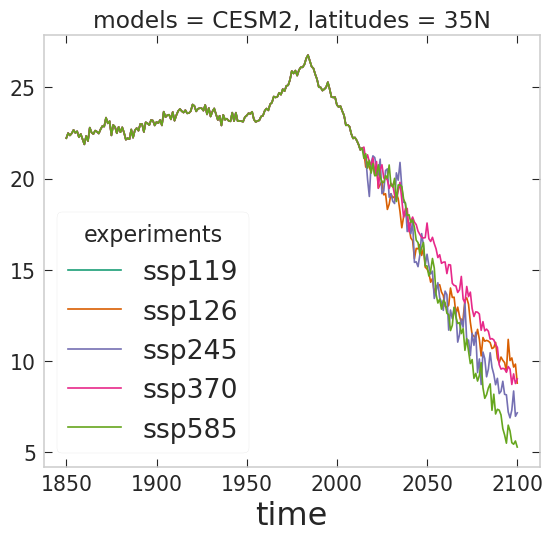

In [33]:
model='CESM2'
amoc6.sel(latitudes='35N').sel(models=model).groupby('experiments').mean(dim = 'ensemble_members').plot.line(x='time',hue='experiments')

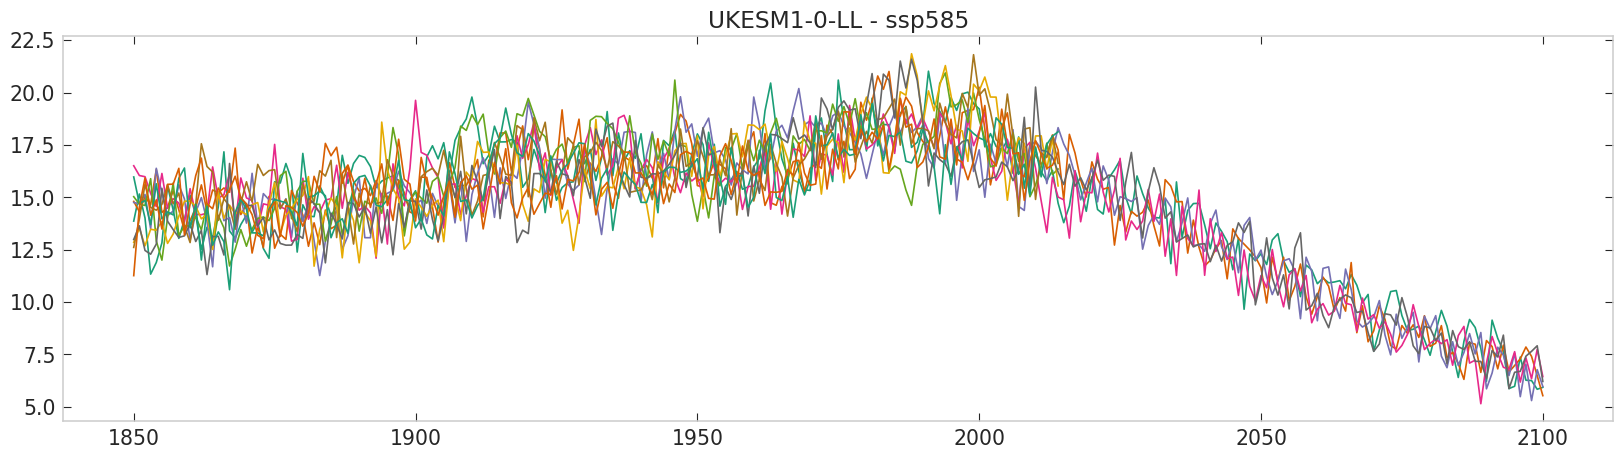

In [44]:
fig, ax = plt.subplots(figsize=(20,5))
model='UKESM1-0-LL'
experiment = 'ssp585'
data = amoc6.sel(latitudes='35N').sel(models=model).sel(experiments=experiment)
time = data.time
for i in range(10):
    amoc = data[i,:]
    plt.plot(time, amoc)
plt.title(model+' - '+experiment)
plt.show()

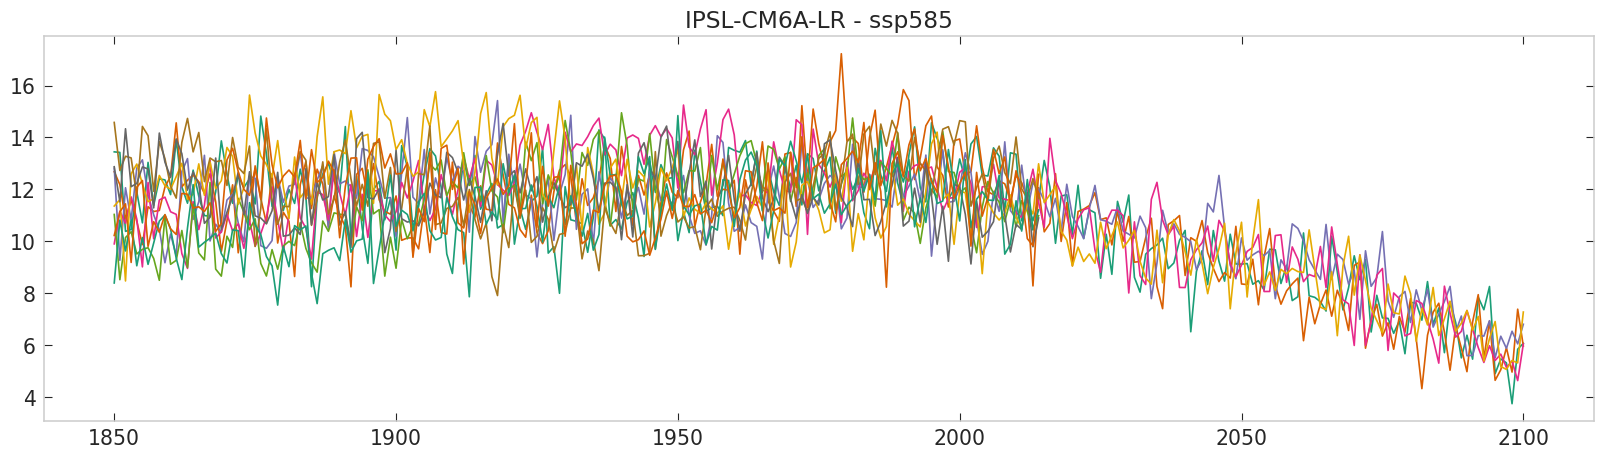

In [45]:
fig, ax = plt.subplots(figsize=(20,5))
model='IPSL-CM6A-LR'
experiment = 'ssp585'
data = amoc6.sel(latitudes='35N').sel(models=model).sel(experiments=experiment)
time = data.time
for i in range(10):
    amoc = data[i,:]
    plt.plot(time, amoc)
plt.title(model+' - '+experiment)
plt.show()

In [33]:
all_pr_paths = get_pr_paths_dict(exp='abrupt-4xCO2')

/p/tmp/mayayami/SYNDA/data/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/abrupt-4xCO2/
/p/tmp/mayayami/SYNDA/data/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/abrupt-4xCO2/
/p/tmp/mayayami/SYNDA/data/CMIP6/CMIP/BCC/BCC-ESM1/abrupt-4xCO2/
/p/tmp/mayayami/SYNDA/data/CMIP6/CMIP/BCC/BCC-CSM2-MR/abrupt-4xCO2/
/p/tmp/mayayami/SYNDA/data/CMIP6/CMIP/NCAR/CESM2-WACCM/abrupt-4xCO2/
/p/tmp/mayayami/SYNDA/data/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/
/p/tmp/mayayami/SYNDA/data/CMIP6/CMIP/SNU/SAM0-UNICON/abrupt-4xCO2/
/p/tmp/mayayami/SYNDA/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/abrupt-4xCO2/
/p/tmp/mayayami/SYNDA/data/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/abrupt-4xCO2/
/p/tmp/mayayami/SYNDA/data/CMIP6/CMIP/MOHC/HadGEM3-GC31-MM/abrupt-4xCO2/
/p/tmp/mayayami/SYNDA/data/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/abrupt-4xCO2/
/p/tmp/mayayami/SYNDA/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/abrupt-4xCO2/
/p/tmp/mayayami/SYNDA/data/CMIP6/CMIP/CCCma/CanESM5/abrupt-4xCO2/
/p/tmp/mayayami/SYNDA/data/CMIP6/CMIP/CAMS/CAMS-CSM1-0/abrupt-4xCO2/
/p/tmp/mayayami/SYN